In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

from scipy import ndimage as ndi
import napari
import numpy as np
import cv2
import tifffile

from oiffile import OifFile
from confocal_3D.OifImageViewer import OifImageViewer

Using OpenCL device NVIDIA RTX A5000


In [4]:
path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



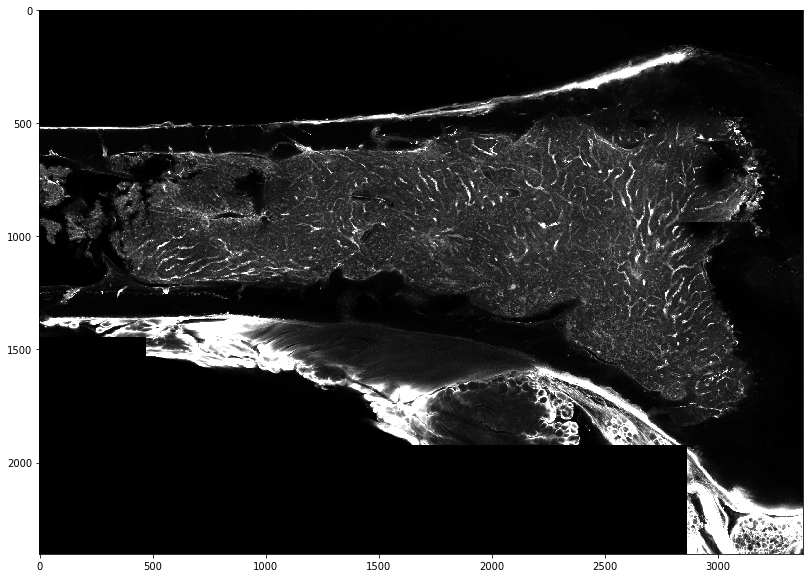

In [7]:
original_image = cle.push(viewer._arr[1])

plt.figure(figsize=(15,10))
cle.imshow(original_image[40])

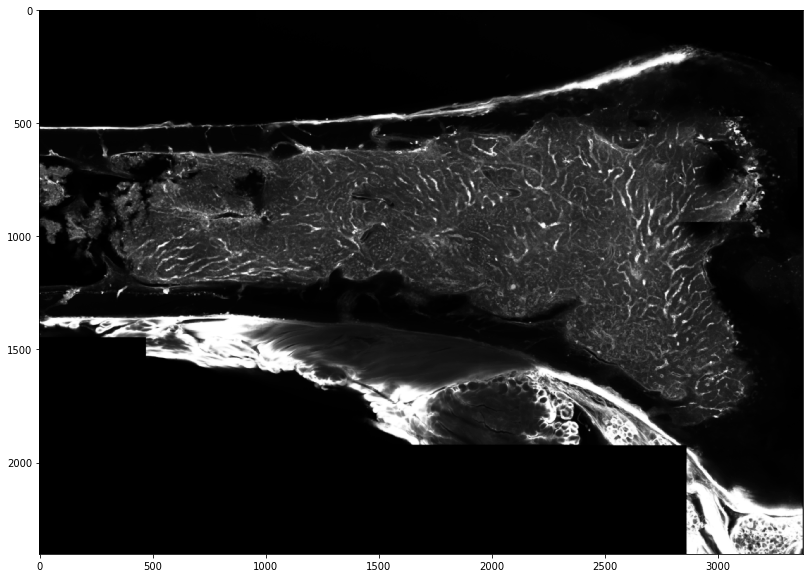

In [8]:
img_gaussian = cle.gaussian_blur(original_image, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(15,10))
cle.imshow(img_gaussian[40])

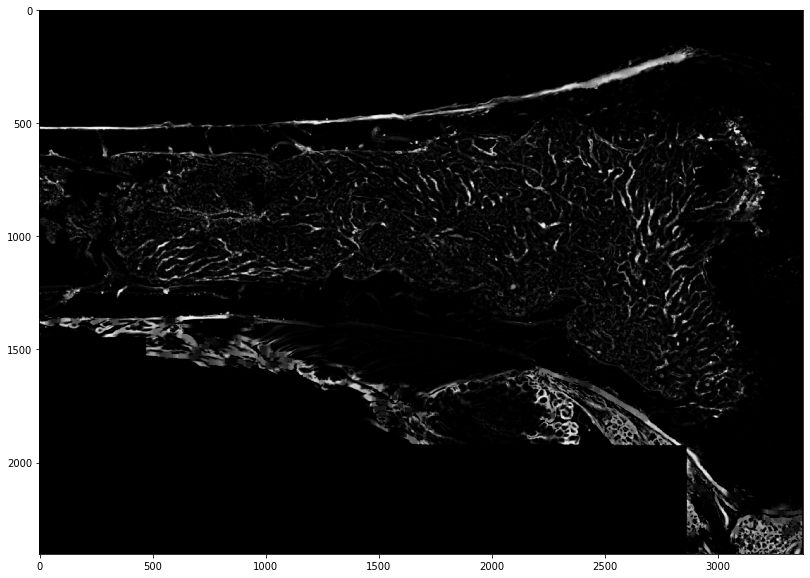

In [9]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(15,10))
cle.imshow(backgrund_subtracted[40])

In [ ]:
# thicker_membranes = cle.maximum_sphere(backgrund_subtracted, radius_x=3, radius_y=3, radius_z=3)

# plt.figure(figsize=(15,10))
# cle.imshow(thicker_membranes[40])

In [ ]:
# thresh1 = cle.threshold_otsu(thicker_membranes)

# plt.figure(figsize=(15,10))
# cle.imshow(thresh1[40])

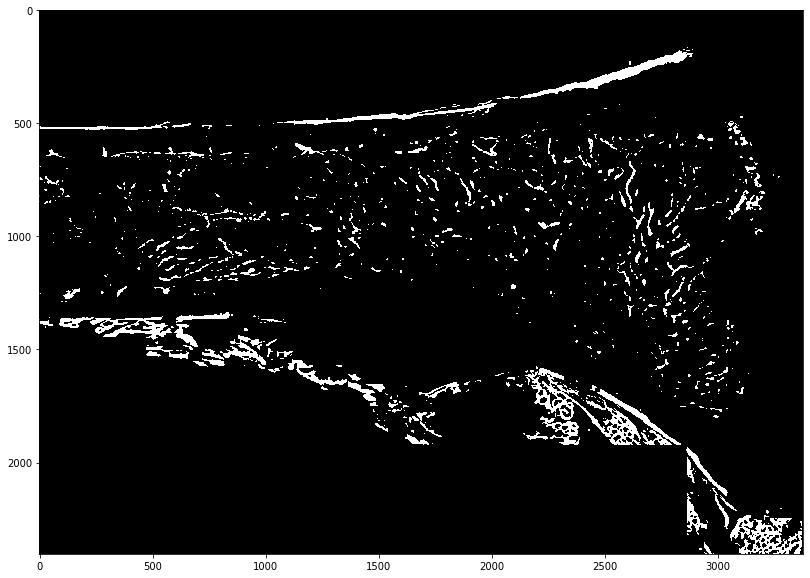

In [10]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(15,10))
cle.imshow(thresh2[40])

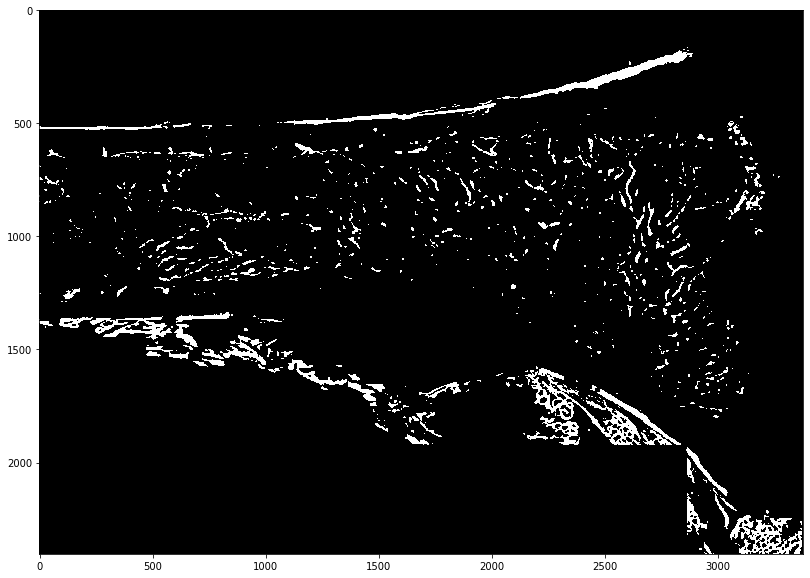

In [11]:
# Morphological openning
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(15,10))
cle.imshow(dilation[40])

In [ ]:

dilation.shape

In [13]:
del erosion, backgrund_subtracted, img_gaussian, original_image

NameError: name 'erosion' is not defined

(76, 2404, 3376)


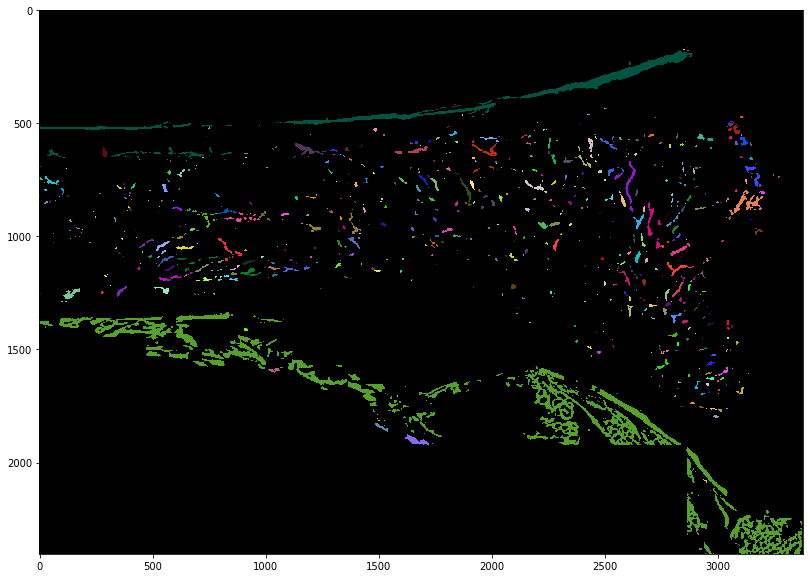

In [14]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(15,10))
cle.imshow(labels[40], labels=True)


In [ ]:
cle.statistics_of_background_and_labelled_pixels(dilation, labels)

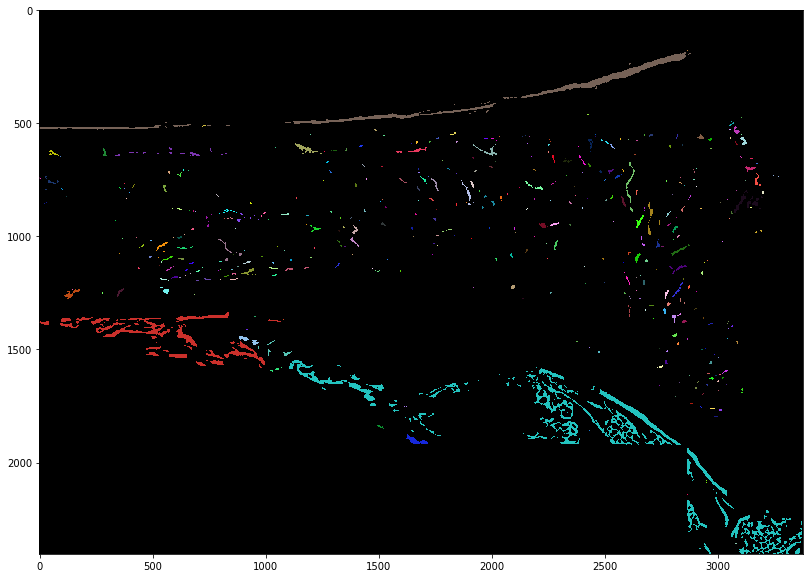

In [15]:
labels = cle.erode_labels(labels, relabel_islands=True)
labels = cle.erode_labels(labels, relabel_islands=True)
plt.figure(figsize=(15,10))
cle.imshow(labels[40], labels=True)

In [ ]:
dil3d = cle.dilate_labels(labels)
plt.figure(figsize=(15,10))
cle.imshow(dil3d[40], labels=True)

In [ ]:
del dilation, labels
smalls_filtered_out = cle.exclude_labels_outside_size_range(dil3d, None, 240, 6580)
plt.figure(figsize=(15,10))
cle.imshow(smalls_filtered_out[40], labels=True)

In [ ]:
D = cle.euclidean_distance_from_label_centroid_map(smalls_filtered_out)
plt.figure(figsize=(15,10))
cle.imshow(D[40], labels=False)

In [ ]:
max_peaks = cle.detect_maxima_box(D)
plt.figure(figsize=(15,10))
cle.imshow(max_peaks[40], labels=False)

In [ ]:
binarized = 3000 * (smalls_filtered_out > 0)

In [ ]:
plt.figure(figsize=(15,10))
cle.imshow(binarized[40], labels=True)

In [ ]:
image_with_segmentation = np.concatenate((viewer.arr, np.expand_dims(cle.pull(binarized), axis=0)), axis=0)
image_with_segmentation.shape

In [ ]:
viewer.save_as_tif_sequence(image_with_segmentation, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/NG2_segmentation/FV10__20190620_111343_NG2segmented")

In [ ]:
np.unique(cle.pull(binarized))

In [ ]:
image_with_segmentation.dtype